In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle

torch.manual_seed(1)

## LSTM Model 
![Alt text](https://upload.wikimedia.org/wikipedia/commons/thumb/5/53/Peephole_Long_Short-Term_Memory.svg/450px-Peephole_Long_Short-Term_Memory.svg.png)

In [3]:
lstm = nn.LSTM(3, 3)  # Input dim is 3, output dim is 3
inputs = [torch.randn(1, 3) for _ in range(5)]  # make a sequence of length 5

# initialize the hidden state.
hidden = (torch.randn(1, 1, 3),
          torch.randn(1, 1, 3))
for i in inputs:
    # Step through the sequence one element at a time.
    # after each step, hidden contains the hidden state.
    out, hidden = lstm(i.view(1, 1, -1), hidden)

# alternatively, we can do the entire sequence all at once.
# the first value returned by LSTM is all of the hidden states throughout
# the sequence. the second is just the most recent hidden state
# (compare the last slice of "out" with "hidden" below, they are the same)
# The reason for this is that:
# "out" will give you access to all hidden states in the sequence
# "hidden" will allow you to continue the sequence and backpropagate,
# by passing it as an argument  to the lstm at a later time
# Add the extra 2nd dimension
inputs = torch.cat(inputs).view(len(inputs), 1, -1)
hidden = (torch.randn(1, 1, 3), torch.randn(1, 1, 3))  # clean out hidden state
out, hidden = lstm(inputs, hidden)
print(out.shape)
print(hidden)

torch.Size([5, 1, 3])
(tensor([[[-0.3368,  0.0959, -0.0538]]], grad_fn=<StackBackward>), tensor([[[-0.9825,  0.4715, -0.0633]]], grad_fn=<StackBackward>))


In [7]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    return torch.tensor(idxs, dtype=torch.long)


# training_data = [
#     ("The dog ate the apple".split(), ["DET", "NN", "V", "DET", "NN"]),
#     ("Everybody read that book".split(), ["NN", "V", "DET", "NN"])
# ]

train_sampler =pickle.load(open('data/train.pkl','rb'))
valid_sampler = pickle.load(open('data/valid.pkl','rb'))
dataset = train_sampler+valid_sampler
print(len(train_sampler))
print(len(valid_sampler))
word_to_ix = {}
for tags, sent in dataset:
    for word in sent:
        if word not in word_to_ix:
            word_to_ix[word] = len(word_to_ix)
print(word_to_ix)
tag_to_ix = {'sports': 0, 'business': 1, 'politics': 2, 'society': 3}
# These will usually be more like 32 or 64 dimensional.
# We will keep them small, so we can see how the weights change as we train.
EMBEDDING_DIM = 300
HIDDEN_DIM = 100

2892
722
{'毒': 0, '販': 1, '槍': 2, '自': 3, '抵': 4, '太': 5, '陽': 6, '穴': 7, '與': 8, '警': 9, '對': 10, '峙': 11, '1': 12, '小': 13, '時': 14, '土': 15, '城': 16, '鵝': 17, '肉': 18, '名': 19, '店': 20, '遭': 21, '縱': 22, '火': 23, '死': 24, '4': 25, '傷': 26, '刑': 27, '事': 28, '局': 29, '前': 30, '主': 31, '秘': 32, '╱': 33, '許': 34, '瑞': 35, '山': 36, '包': 37, '庇': 38, '賭': 39, '場': 40, '二': 41, '審': 42, '逆': 43, '轉': 44, '判': 45, '3': 46, '年': 47, '月': 48, '行': 49, '政': 50, '契': 51, '約': 52, '協': 53, '商': 54, '若': 55, '無': 56, '結': 57, '果': 58, '林': 59, '峯': 60, '正': 61, '：': 62, '婦': 63, '聯': 64, '會': 65, '資': 66, '產': 67, '將': 68, '被': 69, '凍': 70, '岱': 71, '鋼': 72, '談': 73, '基': 74, '層': 75, '棒': 76, '球': 77, '禮': 78, '節': 79, '比': 80, '技': 81, '術': 82, '重': 83, '要': 84, '0': 85, '倍': 86, '勇': 87, '士': 88, '換': 89, '戲': 90, '碼': 91, '「': 92, '浪': 93, '花': 94, '兄': 95, '弟': 96, '」': 97, '險': 98, '翻': 99, '船': 100, '義': 101, '氣': 102, '！': 103, '侯': 104, '貞': 105, '雄': 106, '捐': 107, '錢': 108, '蓋': 109, 

In [8]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2tag = nn.Linear(hidden_dim, tagset_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (torch.zeros(1, 1, self.hidden_dim),
                torch.zeros(1, 1, self.hidden_dim))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
#         print(embeds.shape)
        lstm_out, self.hidden = self.lstm(
            embeds.view(len(sentence), 1, -1), self.hidden)
#         print(lstm_out.shape)
#         print(lstm_out.view(len(sentence), -1).shape)
        lstm_out = lstm_out[-1]
#         print(lstm_out.shape)
#         tag_space = self.hidden2tag(lstm_out.view(len(sentence), -1))
        tag_space = self.hidden2tag(lstm_out)
        tag_scores = F.log_softmax(tag_space, dim=1)
        return tag_scores

In [9]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix), len(tag_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
step = 0
# See what the scores are before training
# Note that element i,j of the output is the score for tag j for word i.
# Here we don't need to train, so the code is wrapped in torch.no_grad()
with torch.no_grad():
    inputs = prepare_sequence(train_sampler[0][0], word_to_ix)
    tag_scores = model(inputs)
    print(tag_scores)

for epoch in range(3):  # again, normally you would NOT do 300 epochs, it is toy data
    for tags,sentence in train_sampler:
        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        # Step 2. Get our inputs ready for the network, that is, turn them into
        # Tensors of word indices.
        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = torch.tensor([tag_to_ix[tags]])
        # Step 3. Run our forward pass.
        tag_scores = model(sentence_in)
        # Step 4. Compute the loss, gradients, and update the parameters by
        #  calling optimizer.step()
        loss = loss_function(tag_scores, targets)
        loss.backward()
        optimizer.step()
        step += 1
        if step % 500 == 0:
            print("loss = {} Answer = {} Guess = {}".format(loss,tags,list(tag_to_ix.keys())[tag_scores.topk(1)[1][0].item()]))


tensor([[-1.4624, -1.3997, -1.4402, -1.2561]])
loss = 1.502465844154358 Answer = sports Guess = business
loss = 0.3534810543060303 Answer = business Guess = business
loss = 0.6154921054840088 Answer = business Guess = business
loss = 0.1996302604675293 Answer = society Guess = society
loss = 0.11817574501037598 Answer = sports Guess = sports
loss = 0.08186745643615723 Answer = business Guess = business
loss = 0.01395416259765625 Answer = society Guess = society
loss = 0.06647300720214844 Answer = politics Guess = politics
loss = 0.006915569305419922 Answer = sports Guess = sports
loss = 0.8624922037124634 Answer = business Guess = society
loss = 0.7606347799301147 Answer = society Guess = society
loss = 0.45220494270324707 Answer = business Guess = business
loss = 0.03295111656188965 Answer = politics Guess = politics
loss = 0.0054378509521484375 Answer = politics Guess = politics
loss = 0.9099245071411133 Answer = society Guess = sports
loss = 9.250640869140625e-05 Answer = society Gu

In [12]:
def categoryFromOutput(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return list(tag_to_ix.keys())[category_i], category_i
# See what the scores are after training
with torch.no_grad():
    inputs = prepare_sequence("打球", word_to_ix)
    output = model(inputs)
    print(categoryFromOutput(output))

    # The sentence is "the dog ate the apple".  i,j corresponds to score for tag j
    # for word i. The predicted tag is the maximum scoring tag.
    # Here, we can see the predicted sequence below is 0 1 2 0 1
    # since 0 is index of the maximum value of row 1,
    # 1 is the index of maximum value of row 2, etc.
    # Which is DET NOUN VERB DET NOUN, the correct sequence!

('sports', 0)


tensor([[0.7870, 0.0880, 0.0556, 0.0694],
        [0.1576, 0.6467, 0.1250, 0.0707],
        [0.1774, 0.2258, 0.4919, 0.1048],
        [0.1263, 0.1111, 0.1515, 0.6111]])


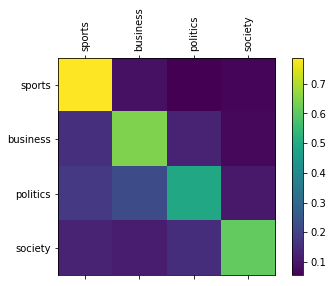

In [13]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
n_categories = 4
confusion = torch.zeros(4, 4)
n_confusion = len(valid_sampler)
for i in range(n_confusion):
    inputs = prepare_sequence(valid_sampler[i][1], word_to_ix)
    output = model(inputs)
    guess, guess_i = categoryFromOutput(output)
    category_i = tag_to_ix[valid_sampler[i][0]]
    confusion[category_i][guess_i] += 1
# Normalize by dividing every row by its sum
for i in range(n_categories):
    confusion[i] = confusion[i] / confusion[i].sum()
print(confusion)
# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion.numpy())
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + list(tag_to_ix.keys()), rotation=90)
ax.set_yticklabels([''] + list(tag_to_ix.keys()))

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()